In [509]:
from multiprocessing import Pool, cpu_count
import gc; gc.enable()
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn import *
from datetime import datetime
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

<h2>...Feature Engineering

## Vorbereitung zum Modellinput

<h3>Der Adaptive Domain Labeling Ansatz setzt ab hier auf. Dateien werden als train.csv und test.csv in SQLite importiert und manipuliert und anschließend in folgenden Dateien bereitgestellt

In [116]:
# Einlesen der Feature Engineerten Daten

## Fertige Feature export Datei #1 einlesen
wsdm_dataset = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\export_wsdm.csv")

## Labels einlesen
wsdm_dataset_labels = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\train_v2.csv")

In [117]:
# Merge die Features der Trainigsdaten
wsdm_dataset = pd.merge(wsdm_dataset, wsdm_dataset_labels, on='msno', how='inner')

In [118]:
#Spalten an Anfang verschieben train
first_column = wsdm_dataset.pop('msno')
second_column = wsdm_dataset.pop('is_churn')
wsdm_dataset.insert(0, 'msno', first_column)
wsdm_dataset.insert(1, 'is_churn', second_column)

In [119]:
# reference: https://medium.com/@vincentteyssier/optimizing-the-size-of-a-pandas-dataframe-for-low-memory-environment-5f07db3d72e
# reference: https://numpy.org/doc/stable/reference/generated/numpy.iinfo.html
# reference: https://numpy.org/doc/stable/reference/generated/numpy.finfo.html

def datatype_changer(dataset):
    # iterating through all the columns in the dataframe
    for col in dataset.columns:
        # getting column's datatype
        col_type = dataset[col].dtype
        
        # checking if datatype of column is 'object' or not
        # if column type is not object
        if (col_type == int) or (col_type == float):
            # getting minimum value of a column
            min_val = dataset[col].min()
            # getting maximum value of a column
            max_val = dataset[col].max()
            # checking whether the datatype contain first 3 characters as int or not, if int
            if str(col_type)[:3] == 'int':
                # cheking the minimal and maximal value for int8, int16, int32 and int64 in numpy
                if min_val > np.iinfo(np.int8).min and max_val < np.iinfo(np.int8).max:
                    dataset[col] = dataset[col].astype(np.int8)
                elif min_val > np.iinfo(np.int16).min and max_val < np.iinfo(np.int16).max:
                    dataset[col] = dataset[col].astype(np.int16)
                elif min_val > np.iinfo(np.int32).min and max_val < np.iinfo(np.int32).max:
                    dataset[col] = dataset[col].astype(np.int32)
                else:
                    dataset[col] = dataset[col].astype(np.int64)
            else:
                # if it is non int, which is ultimately float
                # cheking the minimal and maximal value for float16, float32 and float64 in numpy
                if min_val > np.finfo(np.float16).min and max_val < np.finfo(np.float16).max:
                    dataset[col] = dataset[col].astype(np.float16)
                elif min_val > np.finfo(np.float32).min and max_val < np.finfo(np.float32).max:
                    dataset[col] = dataset[col].astype(np.float32)
                else:
                    dataset[col] = dataset[col].astype(np.float64)
        else:
            # keeping rest of them to category datatype instead of object
            dataset[col] = dataset[col].astype('category')
            
    # returning head of the dataframe
    return dataset

In [120]:
#Doppelte Features entfernen
# wsdm_dataset = wsdm_dataset.loc[:,~wsdm_dataset.T.duplicated(keep='first')]

In [121]:
#Spalten mit Nullvalues entfernen
wsdm_dataset = wsdm_dataset.drop(['DiffMAXdateMAXdate','msno.1'], axis=1, inplace=False)

In [122]:
## Datentypen korrigieren
wsdm_dataset = datatype_changer(wsdm_dataset)

In [123]:
# saving wsdm file
wsdm_dataset.to_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\wsdm_FA_adaptive_dl.csv", index=False)

<h1>3. Prepare Data for Modelling

In [124]:
# loading wsdm dataset
wsdm_dataset = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\wsdm_FA_adaptive_dl.csv")

In [125]:
# getting columns and converting them to list
cols = wsdm_dataset.columns.tolist()
# saving them for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\columns.npz", cols)

In [126]:
# saving actual train dataset
wsdm_dataset.to_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_train.csv", index=False)

<h2> 3.2 Train Test Split

In [11]:
# loading actual wsdm data
wsdm_data = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_train.csv")

In [14]:
# checking for null values
wsdm_data.isnull().values.any()

False

In [15]:
# replacing all nan and infinity to 0
wsdm_data = wsdm_data.replace(np.nan, 0, inplace=False)
wsdm_data = wsdm_data.replace(np.inf, 0, inplace=False)

In [16]:
## Sample 50% of Data due to memory restrictions
wsdm_data = wsdm_data.sample(frac=.5)

In [17]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('msno') and str(feature_name)!=str('is_churn')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

wsdm_dataset = normalize(wsdm_data)

In [22]:
## Spalten mit Null Values entfernen
wsdm_dataset = wsdm_dataset.drop(['DiffMAXtransaction_dateMAXtransaction_date','DiffMAXmembership_expire_dateMAXmembership_expire_date','DiffMINdateMINdate','DiffMINtransaction_dateMINtransaction_date','DiffMINmembership_expire_dateMINmembership_expire_date'], axis=1, inplace=False)

In [26]:
# getting labels for y
labels = wsdm_dataset['is_churn'].values
labels

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [27]:
# getting labels for X
data = wsdm_dataset.drop(['msno', 'is_churn'], axis=1, inplace=False)
data

,AVGregistered_via,AVGpayment_plan_days,AVGgender,AVGcity,AVGbd,AVGpayment_method_id,AVGis_auto_renew,AVGplan_list_price,AVGactual_amount_paid,AVGnum_unq,...,MAXcitystock,MAXbdstock,MAXpayment_method_idstock,MAXis_auto_renewstock,MAXplan_list_pricestock,MAXactual_amount_paidstock,MAXnum_unqstock,MAXnum_25stock,MAXnum_100stock,MAXtotal_secsstock
633810,0.538462,1.0,0.0,0.045455,0.385714,1.000000,0.5,0.550000,0.550000,0.338358,...,0.045455,0.385714,1.000000,0.5,0.550000,0.550000,0.761194,0.266667,0.756757,0.729786
580746,0.000000,1.0,0.0,0.000000,0.385714,1.000000,0.5,0.550000,0.550000,0.223881,...,0.000000,0.385714,1.000000,0.5,0.550000,0.550000,0.223881,0.133333,0.189189,0.202398
57286,0.538462,1.0,0.0,0.045455,0.385714,1.000000,0.5,0.550000,0.550000,0.125373,...,0.045455,0.385714,1.000000,0.5,0.550000,0.550000,0.223881,0.466667,0.148649,0.194260
216879,0.538462,1.0,0.0,0.045455,0.385714,1.000000,0.5,0.827778,0.827778,0.223881,...,0.045455,0.385714,1.000000,0.5,0.827778,0.827778,0.223881,0.133333,0.189189,0.202398
934769,0.692308,1.0,0.5,1.000000,0.385714,0.975610,0.5,0.827778,0.827778,0.345373,...,1.000000,0.385714,0.975610,0.5,0.827778,0.827778,0.910448,0.933333,0.527027,0.533124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423797,0.692308,1.0,0.5,0.227273,0.428571,0.804878,0.5,0.827778,0.827778,0.135373,...,0.227273,0.428571,0.804878,0.5,0.827778,0.827778,0.477612,0.600000,0.364865,0.365987
745578,0.230769,1.0,1.0,0.590909,0.528571,0.951220,0.5,0.827778,0.827778,0.425373,...,0.590909,0.528571,0.951220,0.5,0.827778,0.827778,0.731343,0.466667,0.743243,0.710693
40990,0.692308,1.0,1.0,0.818182,0.328571,0.926829,0.0,0.827778,0.827778,0.233881,...,0.818182,0.328571,0.926829,0.0,0.827778,0.827778,0.597015,0.600000,0.635135,0.642670
47436,0.230769,1.0,1.0,0.590909,0.271429,0.000000,1.0,0.827778,0.827778,0.604478,...,0.590909,0.271429,0.000000,1.0,0.827778,0.827778,0.761194,0.800000,0.540541,0.543765


<h2> Daten aufteilen in 70% Training und 30% Test

In [28]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(339836, 134) (339836,)
(145644, 134) (145644,)


In [29]:
# converting X_train to numpy array
wsdm_arr = X_train.values
wsdm_arr

array([[0.53846154, 1.        , 0.        , ..., 0.2       , 0.45945946,
        0.42096921],
       [0.30769231, 1.        , 0.5       , ..., 0.8       , 0.33783784,
        0.41992591],
       [0.69230769, 1.        , 1.        , ..., 0.8       , 0.82432432,
        0.73604542],
       ...,
       [0.53846154, 1.        , 0.        , ..., 0.2       , 0.04054054,
        0.04577291],
       [0.53846154, 1.        , 0.        , ..., 0.13333333, 0.2027027 ,
        0.20897091],
       [0.53846154, 1.        , 0.5       , ..., 0.66666667, 0.87837838,
        0.85654643]])

In [30]:
wsdm_arr.shape

(339836, 134)

In [31]:
# saving it for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_train.npz", wsdm_arr)

In [32]:
# displaying y_train
wsdm_labels_arr = y_train
wsdm_labels_arr

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [33]:
wsdm_labels_arr.shape

(339836,)

In [34]:
# saving it for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_wsdm_labels.npz", wsdm_labels_arr)

In [35]:
# converting X_test to numpy array
X_arr = X_test.values
X_arr

array([[0.69230769, 1.        , 1.        , ..., 0.93333333, 0.71621622,
        0.72404749],
       [0.69230769, 1.        , 0.        , ..., 0.86666667, 0.86486486,
        0.97078764],
       [0.53846154, 1.        , 0.        , ..., 0.13333333, 0.18918919,
        0.20239813],
       ...,
       [0.53846154, 1.        , 0.        , ..., 0.13333333, 0.60810811,
        0.59363515],
       [0.53846154, 1.        , 1.        , ..., 0.4       , 0.14864865,
        0.13573134],
       [0.69230769, 1.        , 1.        , ..., 0.73333333, 0.56756757,
        0.55795433]])

In [36]:
# checking shape of test array
X_arr.shape

(145644, 134)

In [37]:
# saving it for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_test.npz", X_arr)

In [38]:
# displaying y_test
X_labels_arr = y_test
X_labels_arr

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [39]:
# checking shape of test labels array
X_labels_arr.shape

(145644,)

In [40]:
# saving it for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_test_labels.npz", X_labels_arr)

<h1> 5. Modelling

In [22]:
# loading library
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
#from prettytable import PrettyTable

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#import lightgbm as lgb
import xgboost as xgb
from sklearn import metrics
#import catboost as cb


In [23]:
X_train = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_train.npz")
y_train = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_wsdm_labels.npz")
X_test = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_test.npz")
y_test = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\actual_test_labels.npz")

In [24]:
X_train = X_train['arr_0']
X_test = X_test['arr_0']
y_train = y_train['arr_0']
y_test = y_test['arr_0']

# getting shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(679672, 134) (679672,)
(291288, 134) (291288,)


In [25]:
# loading columns
cols = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_4\columns.npz")
# converting numpy array to python list
cols = cols['arr_0'].tolist()
# removing first two cols 'msno' and 'is_churn'
cols.remove('msno')
cols.remove('is_churn')

<h1> Logistic Regression

In [ ]:
%%time

# fitting logistic regression model with best parameter values
lr_model = LogisticRegression(penalty='l2', tol=0.001, C=10, solver='newton-cg', class_weight='balanced', n_jobs=-1)
lr_model.fit(X_train, y_train)

In [7]:
# Reference: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
# saving the trained logistic regression ML model
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_4\finalized_model_lr.sav"
joblib.dump(lr_model, filename)

['D:\\Work_Masterarbeit\\wsdm\\preprocessed_4\\finalized_model_lr.sav']

In [8]:
# loading the best model from disk
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_4\finalized_model_lr.sav"
loaded_model = joblib.load(filename)

In [9]:
## Logloss
# predicting probabilities for X_cv
pred_test = loaded_model.predict_proba(X_test)
# getting probabilities corresponding to class label 1 only
pred_test = pred_test[:,1]
# calculating log loss
print('Test log-loss: ', log_loss(y_test, pred_test))

Test log-loss:  0.38628029454606805


<h3>Model Evaluation

In [10]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

lr_predict=lr_model.predict(X_test)
lr_predict


print('Accuracy:', accuracy_score(y_test, lr_predict))
print('F1 score weighted:', f1_score(y_test, lr_predict,average='weighted'))
print('F1 score macro:', f1_score(y_test, lr_predict, average='macro'))
print('Recall:', recall_score(y_test, lr_predict,average='weighted'))
print('Precision:', precision_score(y_test, lr_predict,average='weighted'))
print('\n clasification report:\n', classification_report(y_test, lr_predict))
print('\n confussion matrix:\n',confusion_matrix(y_test, lr_predict))

Accuracy: 0.8706503529153278
F1 score weighted: 0.8881011628878378
F1 score macro: 0.7209141783253386
Recall: 0.8706503529153278
Precision: 0.9203116988346374

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.93    132379
           1       0.39      0.76      0.52     13265

    accuracy                           0.87    145644
   macro avg       0.68      0.82      0.72    145644
weighted avg       0.92      0.87      0.89    145644


 confussion matrix:
 [[116743  15636]
 [  3203  10062]]


<h2> Decision Tree

In [17]:
%%time

# training a decision tree classifier model with best parameters
dtc_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=15, min_samples_split=2, min_samples_leaf=1)
dtc_model.fit(X_train, y_train)

Wall time: 42 s


DecisionTreeClassifier(max_depth=15)

In [ ]:
#Alternative Getunte Hyperparemeter

In [26]:
%%time

# training a decision tree classifier model with best parameters
dtc_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, min_samples_split=2, min_samples_leaf=1)
dtc_model.fit(X_train, y_train)

Wall time: 14.3 s


DecisionTreeClassifier(max_depth=5)

In [31]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
# saving the decision tree classifier model
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_4\finalized_model_dtc.sav"
joblib.dump(dtc_model, filename)

['D:\\Work_Masterarbeit\\wsdm\\preprocessed_4\\finalized_model_dtc.sav']

In [32]:
# loading the best decision tree classifier model from disk
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_4\finalized_model_dtc.sav"
loaded_model = joblib.load(filename)

In [33]:
## Logloss
# predicting probabilities for X_cv
pred_test = loaded_model.predict_proba(X_test)
# getting probabilities corresponding to class label 1 only
pred_test = pred_test[:,1]
# calculating log loss
print('Test log-loss: ', log_loss(y_test, pred_test))

Test log-loss:  0.08018315207449239


<h3> Model Evaluation

In [30]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

dtc_modelpred=dtc_model.predict(X_test)
dtc_modelpred


print('Accuracy:', accuracy_score(y_test, dtc_modelpred))
print('F1 score weighted:', f1_score(y_test, dtc_modelpred,average='weighted'))
print('F1 score macro:', f1_score(y_test, dtc_modelpred, average='macro'))
print('Recall:', recall_score(y_test, dtc_modelpred,average='weighted'))
print('Precision:', precision_score(y_test, dtc_modelpred,average='weighted'))
print('\n clasification report:\n', classification_report(y_test, dtc_modelpred))
print('\n confussion matrix:\n',confusion_matrix(y_test, dtc_modelpred))

Accuracy: 0.9771772266622724
F1 score weighted: 0.9766833474727454
F1 score macro: 0.927075050495153
Recall: 0.9771772266622724
Precision: 0.9765803989322328

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99    265175
           1       0.91      0.83      0.87     26113

    accuracy                           0.98    291288
   macro avg       0.95      0.91      0.93    291288
weighted avg       0.98      0.98      0.98    291288


 confussion matrix:
 [[263041   2134]
 [  4514  21599]]


<h3>Randomforest

In [58]:
%%time

# training the random forest classifier for best hyper parameters
rf_model = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=15, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', bootstrap=True, n_jobs=-1)
rf_model.fit(X_train, y_train)

Wall time: 3min 11s


RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000, n_jobs=-1)

In [163]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

rf_modelpred=rf_model.predict(X_test)
rf_modelpred


print('Accuracy:', accuracy_score(y_test, rf_modelpred))
print('F1 score weighted:', f1_score(y_test, rf_modelpred,average='weighted'))
print('F1 score macro:', f1_score(y_test, rf_modelpred, average='macro'))
print('Recall:', recall_score(y_test, rf_modelpred,average='weighted'))
print('Precision:', precision_score(y_test, rf_modelpred,average='weighted'))
print('\n clasification report:\n', classification_report(y_test, rf_modelpred))
print('\n confussion matrix:\n',confusion_matrix(y_test, rf_modelpred))

Accuracy: 0.9815749361456703
F1 score weighted: 0.9815703214999454
F1 score macro: 0.943529409904396
Recall: 0.9815749361456703
Precision: 0.9815657618957192

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    265175
           1       0.90      0.90      0.90     26113

    accuracy                           0.98    291288
   macro avg       0.94      0.94      0.94    291288
weighted avg       0.98      0.98      0.98    291288


 confussion matrix:
 [[262506   2669]
 [  2698  23415]]


In [59]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
# saving the decision tree classifier model
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_4\finalized_model_rf.sav"
joblib.dump(rf_model, filename)

['D:\\Work_Masterarbeit\\wsdm\\preprocessed_4\\finalized_model_rf.sav']

In [60]:
# loading the best decision tree classifier model from disk
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_4\finalized_model_rf.sav"
loaded_model = joblib.load(filename)

In [61]:
## Logloss
# predicting probabilities for X_cv
pred_test = loaded_model.predict_proba(X_test)
# getting probabilities corresponding to class label 1 only
pred_test = pred_test[:,1]
# calculating log loss
print('Test log-loss: ', log_loss(y_test, pred_test))

train log-loss:  0.033807998045762004
cv log-loss:  0.04629969230037218


<h3>XGBoost

In [55]:
# creating DMatrix for train, cv, and test
train = xgb.DMatrix(X_train, label=y_train, feature_names=cols, nthread=-1)
test = xgb.DMatrix(X_test, label=y_test, feature_names=cols, nthread=-1)

In [56]:
# setting parameters
params = {'objective' : 'binary:logistic',
          'eval_metric' : 'logloss'}

In [57]:
%%time

# train the xgboost model
xgb_model = xgb.train(params, train, 12, verbose_eval=True)

Wall time: 5.92 s


In [39]:
# saving model
xgb_model.save_model('finalized_model_xgb_train.sav')

In [40]:
# loading model
xgb_model = xgb.Booster(model_file='finalized_model_xgb_train.sav')

In [41]:
# predicting probabilities for train data
pred_train = xgb_model.predict(train)
# calculating log-loss
log_loss(y_train, pred_train)

0.057003232714586655

In [42]:
# predicting probabilities for train data
pred_test = xgb_model.predict(test)
# calculating log-loss
log_loss(y_test, pred_test)

0.058018775835654714

## Feature Importance

Text(0.5, 1.0, 'Feature importance for xgboost model')

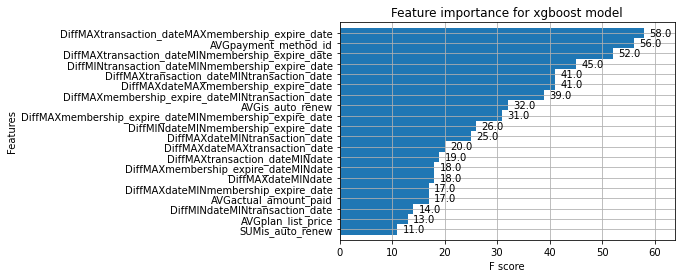

In [17]:
# plotting important features
xgb.plot_importance(xgb_model, max_num_features=20, height=1)
plt.title('Feature importance for xgboost model')

## Model Evaluation

In [59]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

xgb_modelpred=xgb_model.predict(test)
xgb_modelpred



array([0.02627885, 0.9876609 , 0.01698989, ..., 0.01291492, 0.01291492,
       0.01291492], dtype=float32)